<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/Autoencoders/RNN/With%20Attention/English2Hindi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!ls
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/Udacity/Machine Transliteration/")
!ls

sample_data
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 146364 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0

## Setting Up Dependencies

In [2]:
import torch
import random
import numpy as np
from io import open
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os, string, random, time, math
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device_gpu = torch.device('cuda:0')
print(device_gpu)

1
Tesla T4
cuda:0


## Dataset

### Alphabets Setup

In [4]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

In [5]:
print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [6]:
print("Hindi character at index 2304 is : ",chr(2304))

Hindi character at index 2304 is :  ऀ


In [7]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
print(hindi_alphabets)

['ऀ', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', 'ऺ', 'ऻ', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॎ', 'ॏ', 'ॐ', '॑', '॒', '॓', '॔', 'ॕ', 'ॖ', 'ॗ', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', 'ॣ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॳ', 'ॴ', 'ॵ', 'ॶ', 'ॷ', 'ॸ', 'ॹ', 'ॺ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ']


In [8]:
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

In [9]:
print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

### Helper functions for data pre-processing

In [10]:
import re

In [11]:
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

In [12]:
# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

In [13]:
# Remove all Hindi non-letters
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

### Dataset Loading

In [14]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET 

In [15]:
class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch

In [16]:
train_data = TransliterationDataLoader('NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('NEWS2012-Ref-EnHi-1000.xml')

Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD  -  आज़मनगर
Skipping:  CAPE TOWN  -  केपटाउन
Skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND  -  राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA  -  जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping:  FAKHRUN NISA  -  फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping:  OPENTV  -  ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP  

In [17]:
print("English Words : ", train_data.eng_words[0:5])
print("Hindi Words : ", train_data.hindi_words[0:5])

English Words :  ['RAASAVIHAAREE', 'DEOGAN', 'ROAD', 'SHATRUMARDAN', 'MAHIJUBA']
Hindi Words :  ['रासविहारी', 'देवगन', 'रोड', 'शत्रुमर्दन', 'महिजुबा']


### Basic Data Visualization

In [18]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

Train Set Size:	 20543
Test Set Size:	 1000


In [19]:
print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)


Sample data from train-set:
PARTY - पार्टी
SAINATH - साईनाथ
SHARVANI - शर्वानी
SAHAJA - सहजा
AWARD - अवार्ड
ABHYANKAR - अभयंकर
ASIF - आसफ
BEGUNAH - बेगुनाह
JAGADIP - जगदिप
SLONE - स्लोन


### Encoding the words

In [20]:
word = "DRACULA"
rep = torch.zeros(len(word)+1, 1, len(eng_alpha2index))
print(rep.shape)

torch.Size([8, 1, 27])


In [21]:
for letter_index, letter in enumerate(word):
    pos = eng_alpha2index[letter]
    rep[letter_index][0][pos] = 1

In [22]:
print(rep)

tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

In [23]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

In [24]:
word = "ड्राक्युला"
hindi_characters = [character for character in word]
print(hindi_characters)

['ड', '्', 'र', 'ा', 'क', '्', 'य', 'ु', 'ल', 'ा']


In [25]:
gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long)
print(gt_rep.shape)

torch.Size([11, 1])


In [26]:
for letter_index, letter in enumerate(word):
        pos = hindi_alpha2index[letter]
        gt_rep[letter_index][0] = pos

In [27]:
print(gt_rep)
print(gt_rep.shape)
print(gt_rep[len(word)][0].item())

tensor([[34],
        [78],
        [49],
        [63],
        [22],
        [78],
        [48],
        [66],
        [51],
        [63],
        [ 0]])
torch.Size([11, 1])
0


In [28]:
gt_rep[letter_index+1][0] = hindi_alpha2index[pad_char]
print(gt_rep)
print(gt_rep.shape)
print(gt_rep[len(word)][0].item())

tensor([[34],
        [78],
        [49],
        [63],
        [22],
        [78],
        [48],
        [66],
        [51],
        [63],
        [ 0]])
torch.Size([11, 1])
0


In [29]:
keys = list(hindi_alpha2index.keys())
vals = list(hindi_alpha2index.values())
hindi_dict = [keys[vals.index(character_index)] for character_index in gt_rep[:,0]]
print(hindi_dict)

['ड', '्', 'र', 'ा', 'क', '्', 'य', 'ु', 'ल', 'ा', '-PAD-']


In [30]:
def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [31]:
eng, hindi = train_data.get_random_sample()
print("English word is : ",eng)
print("Hindi word is : ",hindi)

English word is :  FALCON
Hindi word is :  फैल्कन


In [32]:
eng_rep,hindi_gt = word_rep(eng, eng_alpha2index), gt_rep(hindi, hindi_alpha2index)

In [33]:
print(eng_rep)

tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [34]:
print(hindi_gt)

tensor([[44],
        [73],
        [51],
        [78],
        [22],
        [41],
        [ 0]])


### Network Architecture

#### Encoder-Decoder (using GRU)

In [35]:
MAX_OUTPUT_CHARS = 30

In [36]:
class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [37]:
net = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose=True)

In [38]:
def infer(net, word, max_op_chars, device = 'cpu'):
      name_ohe = word_rep(word, eng_alpha2index).to(device)
      out = net.forward(name_ohe, max_output_chars=max_op_chars)
      return out

In [39]:
out = infer(net, 'INDIA', 30)

Encoder output torch.Size([6, 256])
Decoder state torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 129])
U * Encoder output torch.Size([6, 256])
W * Decoder state torch.Size([6, 256])
V torch.Size([6, 1])
Attn torch.Size([1, 6])
Attn LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


In [40]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ठ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ठ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ठ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ठ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ठ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ॼ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ठ


## Training Process

### Core Training

In [41]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        input = word_rep(eng_batch[i], eng_alpha2index, device)
        gt = gt_rep(hindi_batch[i], hindi_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

### Training setup

In [42]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    loss_min = np.Inf # track change in loss
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i+1, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
        if loss_arr[i+1] <= loss_min:
            print('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(loss_min,loss_arr[i+1]))
            torch.save(net.state_dict(), 'with_attention_model.pth')
            loss_min = loss_arr[i+1]

In [43]:
net = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 5000 Loss 0.08325512707233429


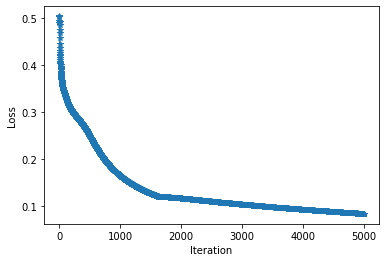




Validation loss decreased (0.083 --> 0.083).  Saving model ...


In [44]:
loss_history = train_setup(net, lr=0.001, n_batches=5000, batch_size = 64, display_freq=20, device = device_gpu)

### Load Model

In [45]:
net.load_state_dict(torch.load('with_attention_model.pth'))

<All keys matched successfully>

## Inference

In [46]:
def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = gt_rep(hindi, hindi_alpha2index, device)
        outputs = infer(net, eng, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

In [47]:
accuracy = calc_accuracy(net) * 100
print('Accuracy without attention ', accuracy)

Accuracy without attention  78.70383089133094


In [48]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [49]:
def list_to_string(s): 
  
    # initialization of string to "" 
    str1 = "" 
  
    # using join function join the list s by  
    # separating words by str1 
    return(str1.join(s)) 

In [50]:
def convert_english_to_hindi(net, input_dict):
  for word in input_dict:
    out = infer(net.cpu(), word, 30)
    hindi_indices = [torch.argmax(out[i]).item() for i in range(len(out)) if torch.argmax(out[i]).item()!=0 ]
    hindi_transliteration =[get_key(hindi_alpha2index,value) for value in hindi_indices]
    print(word,"  -  " ,list_to_string(hindi_transliteration))

In [51]:
input_word = ["DOCTOR", "PARSHANT", "SINGH", "RANA"]
convert_english_to_hindi(net,input_word)

DOCTOR   -   डॉक्टर
PARSHANT   -   पररांत
SINGH   -   सिंह
RANA   -   राना


In [52]:
input_word = ["DOCTOR", "NEERU", "JINDAL"]
convert_english_to_hindi(net,input_word)

DOCTOR   -   डॉक्टर
NEERU   -   नीरू
JINDAL   -   जिन्ल


In [53]:
input_word = ["ANUBHAV", "GUPTA"]
convert_english_to_hindi(net,input_word)

ANUBHAV   -   अनुभव
GUPTA   -   गुप्ता


In [54]:
input_word = ["ASHNA", "BANSAL"]
convert_english_to_hindi(net,input_word)

ASHNA   -   अश्न
BANSAL   -   बंसल


In [55]:
input_word = ["AASHNA", "BAANSAL"]
convert_english_to_hindi(net,input_word)

AASHNA   -   आशना
BAANSAL   -   बानसलल


In [56]:
input_word = ["AASHNA", "BANSAL"]
convert_english_to_hindi(net,input_word)

AASHNA   -   आशना
BANSAL   -   बंसल


In [57]:
input_word = ["CANDY"]
convert_english_to_hindi(net,input_word)

CANDY   -   कैंडी


In [58]:
input_word = ["CANDY", "SINGLA"]
convert_english_to_hindi(net,input_word)

CANDY   -   कैंडी
SINGLA   -   सिंगला


In [59]:
input_word = ["SAKSHI", "SINGLA"]
convert_english_to_hindi(net,input_word)

SAKSHI   -   साक्षी
SINGLA   -   सिंगला


In [60]:
input_word = ["YACHIKA", "GUPTA"]
convert_english_to_hindi(net,input_word)

YACHIKA   -   यचीका
GUPTA   -   गुप्ता
